In [1]:
# Imports, as always...
from random import choice
from tqdm.notebook import tqdm
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector

# QML.
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

In [2]:
# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('numpy', np.__version__)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
numpy                   : 1.24.3


In [3]:
# Random seed setting.
algorithm_globals.random_seed = 42

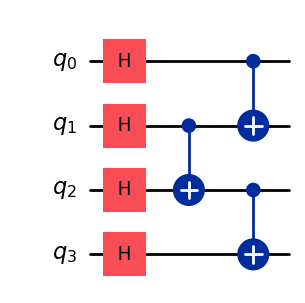

In [4]:
# Setting the unknown unitary to be learnt.
U = QuantumCircuit(4)
U.h(0), U.h(1), U.h(2), U.h(3)
U.cx(1, 2), U.cx(0, 1), U.cx(2, 3)

U.draw('mpl', style='iqp')

# Variational Local Inversions

I personally find the algorithm for obtaining local inversions in Huang et al. (2024) to be underwhelming and, frankly, not as practically useful as it would have you believe. We wonder if it would instead be more general and/or efficient to use a variational algorithm for finding local inversions. Following this, sewing can probably be done in the same way as before.

Suppose I have an unknown unitary $U$, and I want to learn a set of parameters $\theta_i$ for a given parameterised unitary $V$ so that $V(\theta_i)$ will invert the action of $U$ on qubit $i$ (with no regard given to what happens to the other qubits). So, for an arbitrary state $|\psi\rangle=|\psi_1\dots\psi_i\dots\psi_n\rangle$, the action of applying $U$ then $V(\theta_i)$ gives $V(\theta_i)U|\psi_1\dots\psi_i\dots\psi_n\rangle=|\phi_1\dots\psi_i\dots\phi_n\rangle$, and hence the $i$-th qubit has been preserved. More generally, we can consider locally inverting a *set* of qubits $S\subseteq\{1,\dots,n\}$ by finding a parameterisation $\theta_S$.

**I think this is job for a Quantum Neural Network (QNN)**. It all reminds me very much of [this](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html).

![QNN Diagram](./figures/qiskit-qnn-diagram.png)

## As a Quantum Neural Network

QNNs generally have three distinct parts: (1) *data loading* via some feature map applied to a classical set of inputs, which serves to encode the classical data as quantum states; (2) *data processing* via  a parameterised quantum circuit -- an ansatz -- whose tunable parameters (or 'weights') are optimised such that they minimise the cost function; and (3) *measurement* collapsing the output back into the classical world.

For our problem, we can let our unknown unitary $U$ be our feature map, with a dataset of randomised inputs $\mathbf{x}_i\in\{0, 1, 2, 3, 4, 5\}^n$ denoting a tensor product over the six single-qubit stabiliser states. Then, obviously, our paramaterised circuit is $V(\theta_S)$, for which the weights $\theta_S$ must be optimised so that $V(\theta_S)$ (approximately) locally inverts $U$ at the $i$-th qubit for all $i\in S$.

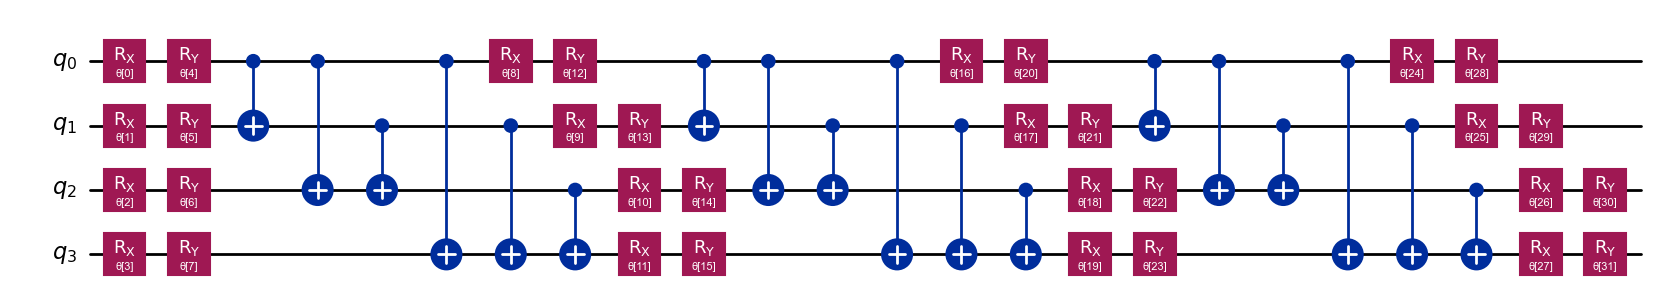

In [5]:
# Define an ansatz.
def build_ansatz(n_qubits, ansatz_reps):
    return TwoLocal(num_qubits=n_qubits, rotation_blocks=['rx', 'ry'], entanglement_blocks='cx', entanglement='full', reps=ansatz_reps, name='Ansatz')

# Demo.
build_ansatz(U.num_qubits, ansatz_reps=3).decompose().draw('mpl', style='iqp')

In [6]:
# Define the full circuit.
def build_experiment_circuit(U, ansatz_reps, target_qubits):
    # Instantiate a new circuit with classical register for measurement.
    q_reg = QuantumRegister(U.num_qubits + len(target_qubits) + 1)
    c_reg = ClassicalRegister(1)
    circuit = QuantumCircuit(q_reg, c_reg)
    
    # Prepare an input state (parameterised) consistent between the two sets of qubits.
    input_parameters = ParameterVector('in', 2 * U.num_qubits)
    for i in range(U.num_qubits):
        circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=i)
        if i in target_qubits: circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=U.num_qubits + i - 1)
        
    # Barrier for clarity.
    circuit.barrier()
        
    # Add U.
    U_copy = U.copy()
    circuit.compose(U_copy, inplace=True)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # Then add the ansatz.
    ansatz = build_ansatz(U.num_qubits, ansatz_reps=ansatz_reps)
    circuit.compose(ansatz, inplace=True)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # SWAP test for loss business.
    aux_idx = circuit.num_qubits - 1
    circuit.h(aux_idx)
    
    for i, q in enumerate(target_qubits):
        circuit.cswap(control_qubit=aux_idx, target_qubit1=q, target_qubit2=U.num_qubits+i)
        
    circuit.h(aux_idx)
    circuit.measure(aux_idx, c_reg[0])
    
    # Return the circuit, the input parameters, and the weight parameters.
    return circuit, input_parameters, ansatz.parameters

In [7]:
# Using an identity interpret as the mapping of the QNNs output.
def identity_interpret(x): return x

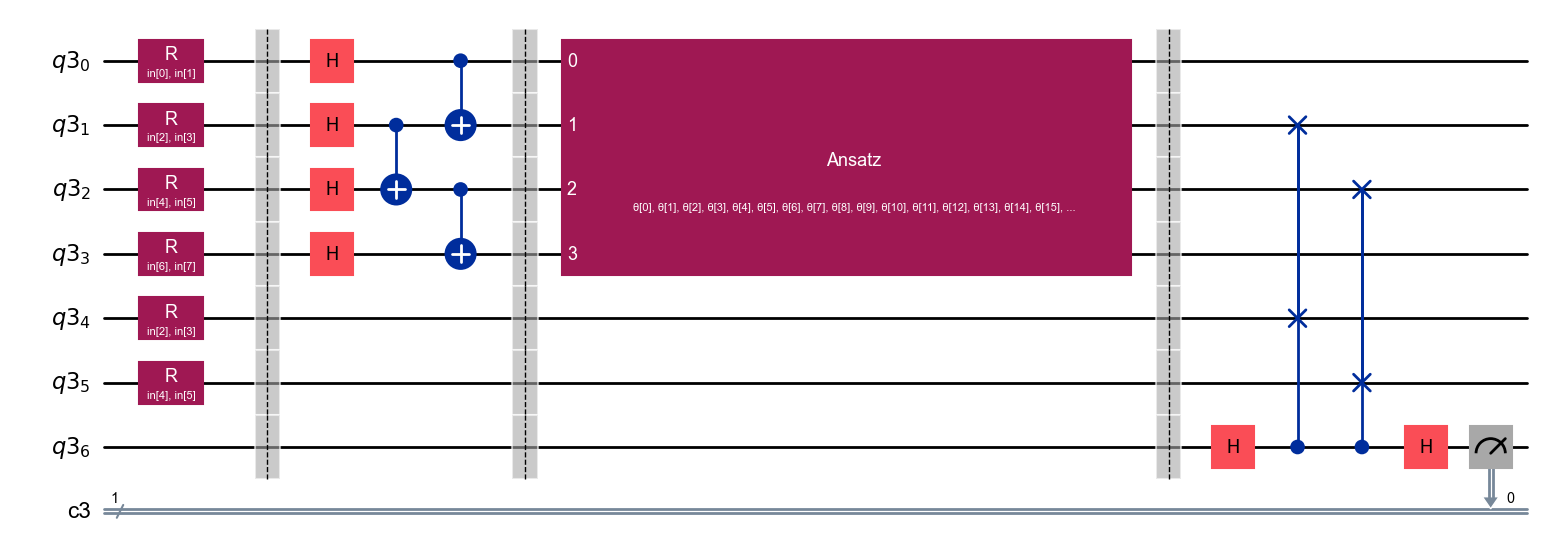

In [20]:
# Build a circuit and get its parameters.
experiment_circuit, input_parameters, weight_parameters = build_experiment_circuit(U, ansatz_reps=10, target_qubits=[1, 2])
experiment_circuit.draw('mpl', style='iqp')

In [21]:
# The QNN object.
qnn = SamplerQNN(
    circuit=experiment_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=identity_interpret,
    output_shape=2,
    input_gradients=True
)

# Demo.
n_samples = 10
qnn.forward(
    input_data=algorithm_globals.random.random(size=(n_samples, len(input_parameters))),
    weights=algorithm_globals.random.random(len(weight_parameters))
)

array([[0.59571542, 0.40428458],
       [0.59555964, 0.40444036],
       [0.57123598, 0.42876402],
       [0.6114755 , 0.3885245 ],
       [0.62377708, 0.37622292],
       [0.57563314, 0.42436686],
       [0.61977572, 0.38022428],
       [0.5967706 , 0.4032294 ],
       [0.61460474, 0.38539526],
       [0.63282146, 0.36717854]])

## Cost Function

It sure would be neat if the cost function could be defined to maximise the fidelity between the input and output state, when ignoring (e.g. tracing out) any qubits not in $S$. Section 4 of [this Qiskit tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html), or the cost function in [this paper](https://arxiv.org/abs/1612.02806) may be of use (both are concerning themselves with autoencoders, but the loss should be very similar). 

Let $S$ be the system within which we would like $V(\theta_S)$ to locally invert $U$, and $\bar S$ be the complementary system containing the remaining qubits, preserved or otherwise. Then our goal is $\max F(|\psi_{S}\rangle\langle\psi_{S}|,\rho^\text{out}_{S})$, where $|\psi_S\rangle\langle\psi_S|=\text{tr}_{\bar S}[|\psi\rangle\langle\psi|]$ and $\rho_S^\text{out}=\text{tr}_{\bar S}[V^\dag(\theta_S)U^\dag|\psi\rangle\langle\psi|UV(\theta_S)]$. Computing this is not easy, however, and scales poorly with a scaling system, so an alternative is suggested...

### SWAP test

A common procedure for comparing two states is the SWAP test (a.k.a. "distance measure", "kernel method", "inner product"), which consists of applying CNOT gates to each qubit (see [the wiki](https://en.wikipedia.org/wiki/Swap_test)). We want a SWAP test over multiple qubits.

The squared inner product between the compared states is approximated by $1-2L/M$, where $L$ is the number of $|1\rangle$ outcomes measured, and $M$ is the total number of tests. To maximise the inner product (to make the states as similar as possible), we must minimise $L/M$. This will be our loss.

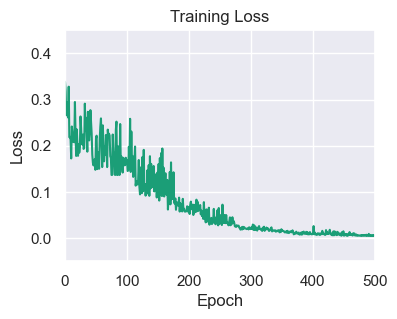

<Figure size 400x300 with 0 Axes>

In [27]:
# It would appear that the only way to do loss tracking is to define a list outside the loss function?
loss_values = []
max_iters = 500

# Define the loss (cost) function according to the SWAP test.
def loss_fn(qnn, inputs, weights):
    # We care only about the probability to measure outcome 1 on the single-qubit classical register.
    loss = np.mean(qnn.forward(input_data=inputs, weights=weights)[:, 1])
    loss_values.append(loss)
    
    # Plotting.
    clear_output(wait=True)
    plt.plot(range(len(loss_values)), loss_values)
    
    # Beautification.
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(-0.05, .45)
    plt.xlim(0, max_iters)
    
    plt.show()
    
    return loss
    
# Random input parameters.
n_samples = 1
xs = algorithm_globals.random.random(size=(n_samples, len(input_parameters)))
#angles = [0, np.pi, -np.pi]
#xs = np.random.choice(angles, size=(n_samples, len(input_parameters)))
    
# Optimiser and starting weights.
optimiser = COBYLA(maxiter=max_iters)
initial_weights = algorithm_globals.random.random(len(weight_parameters))

# Do the thing.
plt.rcParams['figure.figsize'] = (4, 3)
optimal_result = optimiser.minimize(lambda ws : loss_fn(qnn, xs, ws), x0=initial_weights)

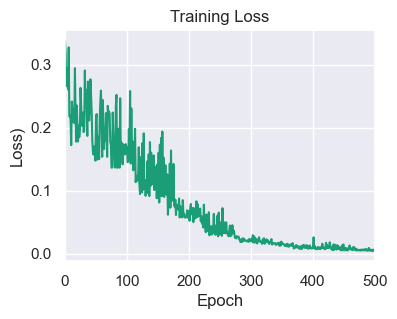

In [31]:
# Let's have that drawn again, but we'll save it this time and everything.

# Plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(range(len(loss_values)), loss_values)
    
# Beautification.
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss)')
ax.set_xlim(0, len(loss_values))

# Save the thing.
plt.savefig('./figures/qnn-loss-curve.pdf', bbox_inches='tight')

In each iteration... we randomly generate a set of $N$ input samples $|\psi_i\rangle$, and portion them into batches of size $B$. For now, we'll go with $B=1$ until we know it's working. Then, in each batch... 
1. Prepare the $|\psi_i\rangle$ together with a copy of the qubits in the target set $S$ and an auxiliary qubit initialised in $|0\rangle$ to yield an input to the circuit $|\psi_i\rangle\otimes|\psi_S\otimes|0\rangle$.
2. Perform $U$ followed by $V(\theta_S)$ on the first $n$ qubits to yield $UV(\theta_S)|\psi\rangle\otimes|\psi_S\rangle\otimes|0\rangle$. Discard the qubits in $UV(\theta_S)|\psi\rangle$ not in $S$ to yield $(UV(\theta_S)|\psi\rangle)_S\otimes|\psi_S\rangle\otimes|0\rangle$.
3. Perform a SWAP test between $(UV(\theta_S)|\psi\rangle)_S$ and $|\psi_S\rangle$, using the auxiliary qubit as the control to be measured. We require $O(1/\varepsilon^2)$ runs of the test to estimate the squared inner produce between them to within $\varepsilon$ additive error.
4. Update the weights $\varepsilon$ according to the loss, determined as before by the estimate of the squared inner product.